In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import pickle
import os
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import collections

In [2]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [3]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [4]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [5]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

reading data/all_codones.pickle


In [6]:
len(all_codones)

972054

In [7]:

def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]

# I've added sorting by frequency
def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
    count = collections.Counter(flat_codones).most_common()
    dictionary = {}
    for word, _ in count:
        dictionary[word] = len(dictionary)
    return dictionary

def process_data(all_codones, dictionary, batch_size, skip_window):
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [8]:
dictionary = make_dictionary(all_codones)

In [9]:
len(dictionary)

9424

In [10]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)

In [11]:
######################

In [57]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W, name=None):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1],
                        padding='SAME', name=name)

def fully_conn(x, input_size, output_size, activ_func=tf.nn.softmax, activ_flag=True, name=""):

    W = weight_variable((input_size, output_size), "W_fc"+name)
    b = bias_variable([output_size], "b_fc"+name)
    if activ_flag:
        return tf.nn.relu(tf.add(tf.matmul(x, W), b), name=name)
    else:
        return tf.add(tf.matmul(x, W), b, name=name)

In [65]:
class SkipGramModel:
    """ Build the graph for word2vec model """

    def __init__(self, vocab_size, embed_size, batch_size, num_sampled, learning_rate):
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.batch_size = batch_size
        self.num_sampled = num_sampled
        self.lr = learning_rate
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        self.saver = tf.train.Saver()  
        # defaults to saving all variables - in this case embed_matrix, nce_weight, nce_bias

    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.center_words = tf.placeholder(tf.int32, shape=[self.batch_size], name='center_words')
            self.target_words = tf.placeholder(tf.int32, shape=[self.batch_size, 1], name='target_words')

    def _create_matrix(self):
        with tf.name_scope("matrix"):
            self.matrix0 = tf.Variable(tf.random_uniform([self.vocab_size, self.embed_size], 
                                                        -1.0, 1.0), name='matrix')
            
    def _create_fc_layer(self):
        with tf.name_scope("fc"):
            fc1 = fully_conn(self.matrix0, self.embed_size, self.embed_size * 2, name='fc1')
            drop = tf.nn.dropout(fc1, 0.5)
            self.embed_matrix = fully_conn(drop, self.embed_size * 2, self.embed_size, 
                                           name='embed_matrix', activ_flag=False)
            
    def _create_loss(self):
        with tf.name_scope("loss"):
            
            embed = tf.nn.embedding_lookup(self.embed_matrix, self.center_words, name='embed')

            # construct variables for NCE loss
            nce_weight = tf.Variable(tf.truncated_normal([self.vocab_size, self.embed_size],
                                                         stddev=1.0 / (self.embed_size ** 0.5)),
                                     name='nce_weight')
            nce_bias = tf.Variable(tf.zeros([self.vocab_size]), name='nce_bias')

            # define loss function to be NCE loss function
            self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                                      biases=nce_bias,
                                                      labels=self.target_words,
                                                      inputs=embed,
                                                      num_sampled=self.num_sampled,
                                                      num_classes=self.vocab_size), name='loss')

    def _create_optimizer(self):
        self.optimizer = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss,
                                                                                 global_step=self.global_step)

    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.loss)
            tf.summary.histogram("histogram loss", self.loss)
            # because you have several summaries, we should merge them all
            # into one op to make it easier to manage
            self.summary_op = tf.summary.merge_all()

    def build_graph(self):
        """ Build the graph for our model """
        self._create_placeholders()
        self._create_matrix()
        self._create_fc_layer()
        self._create_loss()
        self._create_optimizer()
        self._create_summaries()

        
VOCAB_SIZE = len(dictionary)
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 16  # Number of negative examples to sample.
LEARNING_RATE = .01
NUM_TRAIN_STEPS = 1500000
SKIP_STEP = 2000

g = tf.Graph()
with g.as_default():
    model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE, BATCH_SIZE, NUM_SAMPLED, LEARNING_RATE)
    model.build_graph()

INFO:tensorflow:Summary name histogram loss is illegal; using histogram_loss instead.


In [66]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)

def train_model(model, batch_gen, num_train_steps, learning_rate, skip_step):
    make_dir('checkpoints')
    with tf.Session(graph=g, config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
#       if that checkpoint exists, restore from checkpoint
        if ckpt and os.path.isfile(ckpt.model_checkpoint_path):
            model.saver.restore(sess, ckpt.model_checkpoint_path)

        total_loss = 0.0  # we use this to calculate late average loss in the last SKIP_STEP steps
        writer = tf.summary.FileWriter('improved_graph/lr' + str(learning_rate), sess.graph)
        initial_step = model.global_step.eval()
        for index in range(initial_step, initial_step + num_train_steps):
            centers, targets = next(batch_gen)
            feed_dict = {model.center_words: centers, model.target_words: targets}
            loss_batch, _, summary, cur_matrix = sess.run([model.loss, model.optimizer, model.summary_op, model.embed_matrix],
                                              feed_dict=feed_dict)
            writer.add_summary(summary, global_step=index)
            total_loss += loss_batch
            if (index + 1) % skip_step == 0:
                #print('Curr matrix 100th row', cur_matrix[100], 
                #      np.min(cur_matrix[100]),  np.max(cur_matrix[100]))
                if (index + 1) % (skip_step * 3) == 0:
                    print('Average loss at step {}: {:5.1f}'.format(index, total_loss / skip_step))
                total_loss = 0.0
                model.saver.save(sess, 'checkpoints/skip-gram', index)

        final_embed_matrix = sess.run(model.embed_matrix)
        return final_embed_matrix

final_embed_matrix = train_model(model, batch_gen, NUM_TRAIN_STEPS, LEARNING_RATE, SKIP_STEP)

Average loss at step 5999:   7.5
Average loss at step 11999:   4.7
Average loss at step 17999:   4.0
Average loss at step 23999:   3.8
Average loss at step 29999:   3.4
Average loss at step 35999:   3.5
Average loss at step 41999:   3.6
Average loss at step 47999:   3.4
Average loss at step 53999:   3.5
Average loss at step 59999:   3.2
Average loss at step 65999:   3.2
Average loss at step 71999:   2.4
Average loss at step 77999:   2.8
Average loss at step 83999:   2.8
Average loss at step 89999:   2.8
Average loss at step 95999:   2.8
Average loss at step 101999:   2.9
Average loss at step 107999:   3.1
Average loss at step 113999:   3.0
Average loss at step 119999:   3.0
Average loss at step 125999:   3.2
Average loss at step 131999:   3.0
Average loss at step 137999:   3.1
Average loss at step 143999:   2.5
Average loss at step 149999:   2.6
Average loss at step 155999:   2.9
Average loss at step 161999:   3.0
Average loss at step 167999:   3.0
Average loss at step 173999:   3.0
Av

Average loss at step 1403999:   3.1
Average loss at step 1409999:   2.9
Average loss at step 1415999:   3.1
Average loss at step 1421999:   3.3
Average loss at step 1427999:   3.2
Average loss at step 1433999:   3.2
Average loss at step 1439999:   3.3
Average loss at step 1445999:   3.1
Average loss at step 1451999:   3.2
Average loss at step 1457999:   3.1
Average loss at step 1463999:   2.6
Average loss at step 1469999:   3.4
Average loss at step 1475999:   3.2
Average loss at step 1481999:   3.0
Average loss at step 1487999:   3.0
Average loss at step 1493999:   2.9
Average loss at step 1499999:   3.2


reading data/all_acid_dicts.pickle


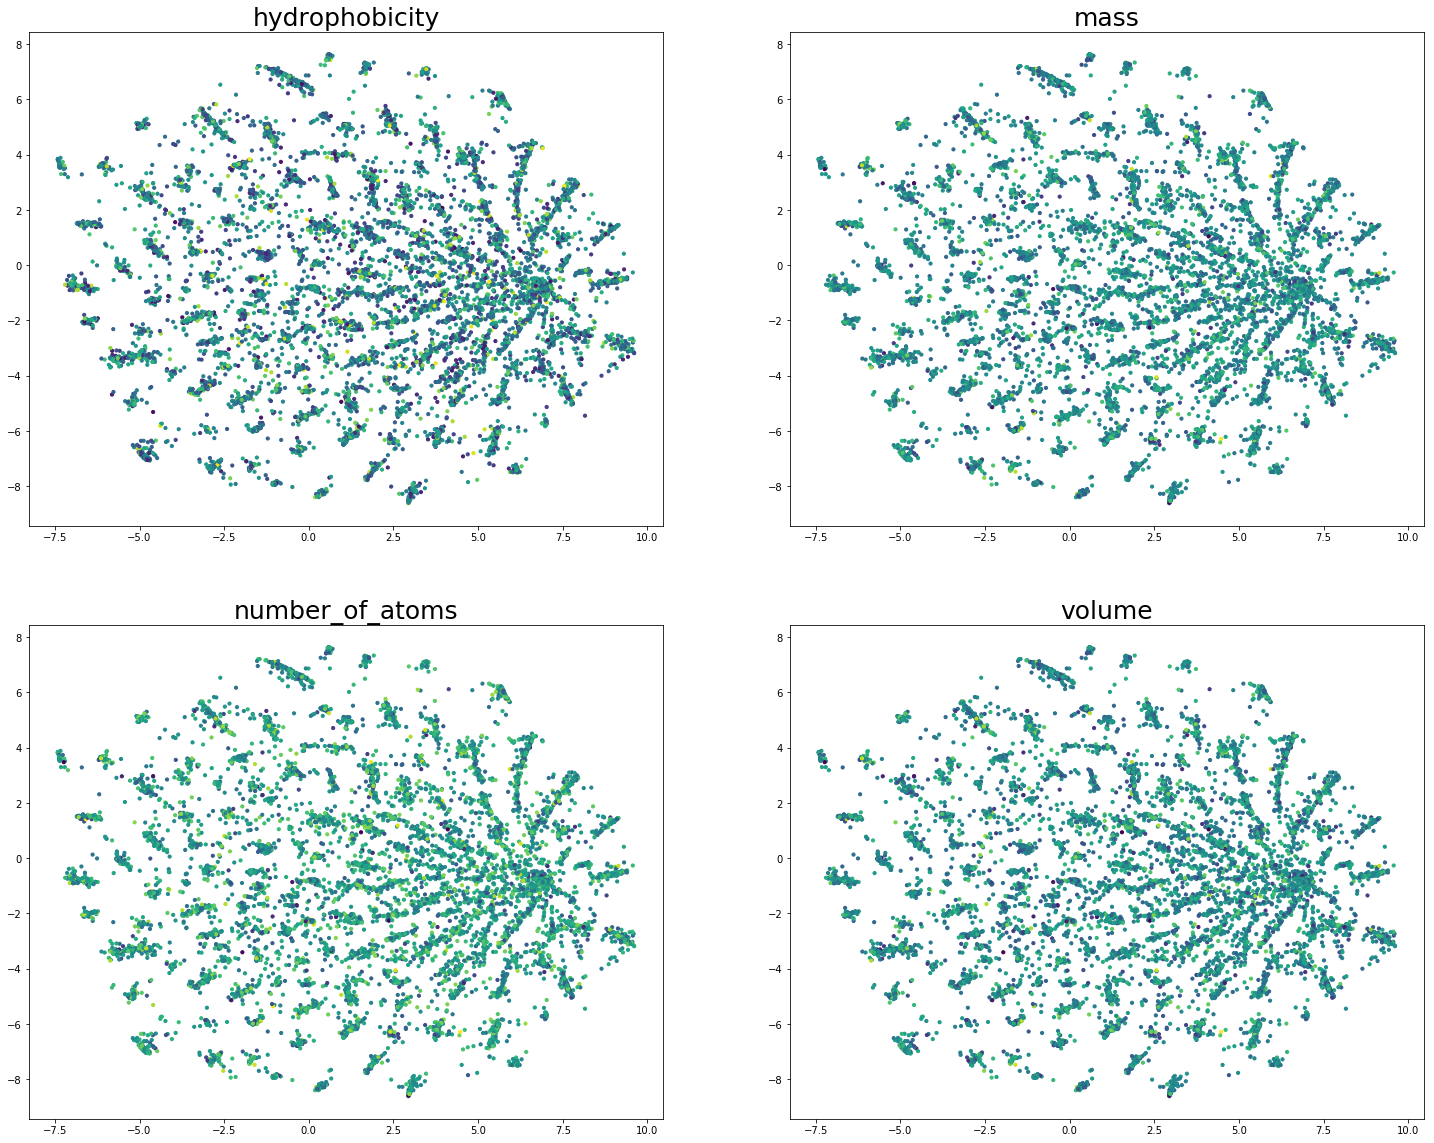

In [67]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(final_embed_matrix)

tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)

filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

all_acid_df = pd.DataFrame(all_acid_dicts)
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')

def plot_embedding_properties(final_df, save=False):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    if save:
        plt.savefig('hw_with_fc.png')
    else:
        plt.show()

plot_embedding_properties(final_df)

In [68]:
def plot_embedding_properties(final_df, save=False):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    if save:
        plt.savefig('hw_with_fc.png')
    else:
        plt.show()

plot_embedding_properties(final_df, save=True)